# Spliting Data

This notebook focuses on exploration using two essential files: the annotations data extracted from the actual screening profile (available in the [IDR repository](https://github.com/IDR/idr0133-dahlin-cellpainting/tree/main/screenA)) and the metadata retrieved from the supplementary section of the [research paper](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-023-36829-x/MediaObjects/41467_2023_36829_MOESM5_ESM.xlsx).

We explore the number of unique compounds associated with each cell injury and subsequently cross-reference this information with the screening profile. The aim is to assess the feasibility of using the data for training a machine learning model to predict cell injury.

Next, with the information collected, we then split our data, identify the controls, and determine our training, test, and holdout sets for subsequent analysis.


In [1]:
import json
import pathlib
import warnings
from collections import defaultdict

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ignoring warnings
warnings.catch_warnings(action="ignore")

catch_warnings()

## Paramters

Below are the parameters defined that are used in this notebook

----

In [2]:
# data directory
data_dir = pathlib.Path("../../data").resolve(strict=True)
results_dir = pathlib.Path("../../results").resolve(strict=True)
data_split_dir = (results_dir / "0.data_splits").resolve()
data_split_dir.mkdir(exist_ok=True)

# data paths
suppl_meta_path = data_dir / "41467_2023_36829_MOESM5_ESM.csv.gz"
screen_anno_path = data_dir / "idr0133-screenA-annotation.csv.gz"

# load data
image_profile_df = pd.read_csv(screen_anno_path)
meta_df = image_profile_df[image_profile_df.columns[:31]]
compounds_df = meta_df[["Compound Name", "Compound Class"]]

suppl_meta_df = pd.read_csv(suppl_meta_path)
cell_injury_df = suppl_meta_df[["Cellular injury category", "Compound alias"]]

## Data splitting and exploration 

In this notebook, we explore the structure of the experiments, focusing on how treatments were applied, conducting quality data checks, and identifying other relationships within the dataset.

Additionally, we extract datasets that will be utilized in our machine learning processes. These datasets encompass our training data, control sets, and holdout sets.

-----

The code below, we extract information regarding various injury types and the corresponding number of compounds known to induce each type of injury.
then, we cross-reference with the selected compounds and identify wells that have a match in the profile data.

This will be our training dataset, where it contains all the cellular injury labeles and it will be used for machine learning modeling 

In [3]:
# getting profilies based on injury and compound type
injury_and_compounds = defaultdict(list)
for injury, compound in cell_injury_df.values.tolist():
    injury_and_compounds[injury].append(compound)

# cross reference selected injury and associated components into the screen profile
injury_profiles = []
for injury_type, compound_list in injury_and_compounds.items():
    sel_profile = image_profile_df[
        image_profile_df["Compound Name"].isin(compound_list)
    ]
    sel_profile.insert(0, "injury_type", injury_type)
    injury_profiles.append(sel_profile)

In [4]:
# creating a dataframe that contains stratified screen Data
injured_df = pd.concat(injury_profiles)

# display df
print(injured_df.shape)
injured_df.head()

(9576, 404)


,injury_type,Plate,Well,Characteristics [Organism],Term Source 1 REF,Term Source 1 Accession,Characteristics [Cell Line],Term Source 2 REF,Term Source 2 Accession,Experimental Condition [Treatment time (h)],...,Nuclei_Texture_InverseDifferenceMoment_DNA_5_0,Nuclei_Texture_InverseDifferenceMoment_RNA_5_0,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumAverage_DNA_10_0,Nuclei_Texture_SumAverage_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0
158,Cytoskeletal,BR00110363,E17,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.561075,0.139535,0.188096,-1.035562,0.655389,0.182888,-0.004066,0.130472,-0.418286,0.283484
159,Cytoskeletal,BR00110363,E18,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.642707,0.052501,0.130166,-1.304556,0.438742,0.187985,0.088121,0.289709,-0.451626,0.461128
160,Cytoskeletal,BR00110363,E19,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.599857,0.184587,0.111444,-1.462714,0.821791,0.229490,0.121207,0.165713,-0.342221,0.388047
161,Cytoskeletal,BR00110363,E20,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.513671,0.137843,0.165498,-1.005157,0.264772,0.169579,0.142331,0.264883,-0.161366,0.337277
162,Cytoskeletal,BR00110363,E21,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.402869,0.083364,0.181626,-1.068167,0.469826,0.411077,0.427186,0.458690,-0.012347,0.658387


>This DataFrame categorizes wells based on their injury types and with its corresponding compounds linked to each specific injury type.
> Note the new column `injury_type` indicating the assigned injury type for each well.
> This assignment is determined by the component with which the well has been treated.

In [5]:
neg_control_df = image_profile_df.loc[image_profile_df["Compound Name"] == "DMSO"]
neg_control_df.insert(0, "injury_type", "Control")
neg_control_df.to_csv("negative_control.csv.gz", compression="gzip", index=False)

print("Shape:", neg_control_df.shape)
neg_control_df.head()

Shape: (9855, 404)


,injury_type,Plate,Well,Characteristics [Organism],Term Source 1 REF,Term Source 1 Accession,Characteristics [Cell Line],Term Source 2 REF,Term Source 2 Accession,Experimental Condition [Treatment time (h)],...,Nuclei_Texture_InverseDifferenceMoment_DNA_5_0,Nuclei_Texture_InverseDifferenceMoment_RNA_5_0,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumAverage_DNA_10_0,Nuclei_Texture_SumAverage_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0
0,Control,BR00110363,B2,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.000098,0.057244,0.160847,-0.083034,-0.023290,-0.066369,-0.015235,-0.035909,-0.013321,-0.032067
1,Control,BR00110363,B3,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.025857,0.099848,0.017477,0.021300,0.058137,-0.097280,-0.073545,-0.044883,-0.089842,-0.015240
2,Control,BR00110363,B4,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.041060,0.119247,0.111741,0.041592,0.224199,-0.088845,0.000327,-0.003115,0.016075,-0.014406
3,Control,BR00110363,B5,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.022156,0.036473,-0.013141,0.008690,0.060860,0.044924,0.040528,0.070877,0.038779,0.072871
4,Control,BR00110363,B6,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.007213,0.023068,0.110361,0.054405,0.030157,0.066480,0.038910,0.048559,0.050371,0.056829


> This dataframe contains all the wells that are considered to be controls. 
> All of these wells have been treated with DMSO

Now that our dataset is labeled, the next step is to concatenate them and begin splitting the dataset into training, testing, and holdout sets. Additionally, we'll extract metadata from the labeled data to gain a better understanding of how the treatments and plates were generated in this experiment.

In [6]:
# creating labeled_df
labeled_df = pd.concat([neg_control_df, injured_df]).reset_index(drop=True)

# only select entries where there are not NaN in the 'injury_type'
labeled_df = labeled_df.loc[~labeled_df["injury_type"].isna()]

# save and display
print("shape:", labeled_df.shape)
labeled_df.head()

shape: (16703, 404)


,injury_type,Plate,Well,Characteristics [Organism],Term Source 1 REF,Term Source 1 Accession,Characteristics [Cell Line],Term Source 2 REF,Term Source 2 Accession,Experimental Condition [Treatment time (h)],...,Nuclei_Texture_InverseDifferenceMoment_DNA_5_0,Nuclei_Texture_InverseDifferenceMoment_RNA_5_0,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumAverage_DNA_10_0,Nuclei_Texture_SumAverage_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0
0,Control,BR00110363,B2,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.000098,0.057244,0.160847,-0.083034,-0.023290,-0.066369,-0.015235,-0.035909,-0.013321,-0.032067
1,Control,BR00110363,B3,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.025857,0.099848,0.017477,0.021300,0.058137,-0.097280,-0.073545,-0.044883,-0.089842,-0.015240
2,Control,BR00110363,B4,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.041060,0.119247,0.111741,0.041592,0.224199,-0.088845,0.000327,-0.003115,0.016075,-0.014406
3,Control,BR00110363,B5,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.022156,0.036473,-0.013141,0.008690,0.060860,0.044924,0.040528,0.070877,0.038779,0.072871
4,Control,BR00110363,B6,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.007213,0.023068,0.110361,0.054405,0.030157,0.066480,0.038910,0.048559,0.050371,0.056829


Here, we're storing the metadata and feature column names into a JSON file to simplify loading during feature engineering processes.

This will be saved in the `results/0.data_splits` directory

In [7]:
# collecting metadata and feature column names
feature_cols = labeled_df.columns[32:].tolist()
raw_features = {
    "compartments": list(set([name.split("_")[0] for name in feature_cols])),
    "meta_features": injured_df.columns[:32].tolist(),
    "feature_cols": feature_cols,
}

# saving into JSON file
with open(data_split_dir / "raw_feature_names.json", mode="w") as stream:
    json.dump(raw_features, stream)

Next we wanted to extract some metadata regarding how many compound and wells are treated with a given compounds

This will be saved in the `results/0.data_splits` directory

In [8]:
meta_injury = []
for injury_type, df in labeled_df.groupby("injury_type"):
    # extract n_wells, n_compounds and unique compounds per injury_type
    n_wells = df.shape[0]
    unique_compounds = list(df["Compound Name"].unique())
    n_compounds = len(unique_compounds)

    # store information
    meta_injury.append([injury_type, n_wells, n_compounds, unique_compounds])

injury_meta_df = pd.DataFrame(
    meta_injury, columns=["injury_type", "n_wells", "n_compounds", "compound_list"]
).sort_values("n_wells", ascending=False)
injury_meta_df.to_csv(data_split_dir / "injury_well_counts_table.csv", index=False)

# display
print("shape:", injury_meta_df.shape)
injury_meta_df

shape: (15, 4)


,injury_type,n_wells,n_compounds,compound_list
0,Control,9855,1,[DMSO]
1,Cytoskeletal,1472,15,"[Nocodazole, Colchicine, Paclitaxel, Vinblasti..."
7,Miscellaneous,1304,39,"[L-Buthionine-(S,R)-sulfoximine, CDDO Im, Cino..."
6,Kinase,1104,13,"[Wortmannin, Staurosporine, PI-103, BEZ-235, A..."
3,Genotoxin,944,22,"[Camptothecin, CX-5461, Doxorubicin, Cladribin..."
5,Hsp90,552,3,"[Radicicol, Geldanamycin, 17-AAG]"
11,Redox,312,12,"[Menadione, PKF118-310, 4-Amino-1-naphthol (HC..."
12,Saponin,288,11,"[Digitonin, Saikosaponin A, Polygalasaponin F,..."
4,HDAC,168,5,"[AR-42, SAHA, ITF 2357, Panobinostat, Apicidin]"
8,Mitochondria,144,4,"[Antimycin A, CCCP, Rotenone, Oligomycin A]"


> This DataFrame contains information about wells associated with a specific injury type.
> It includes details such as the number of components used along with the list of the components responsible for the identified injury type.

/tmp/ipykernel_697435/3270260419.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/home/erikserrano/Programs/miniconda3/envs/metadata-search/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/erikserrano/Programs/miniconda3/envs/metadata-search/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/erikserrano/Programs/miniconda3/envs/metadata-sea

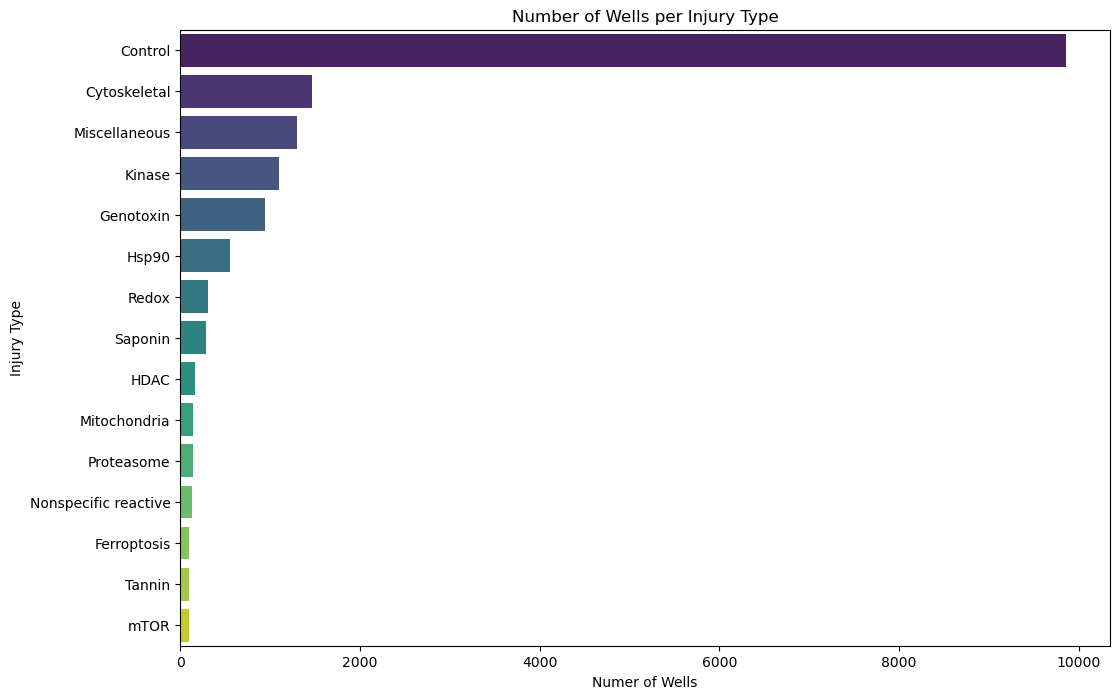

In [9]:
# make a figure of this table
plt.figure(figsize=(12, 8))

# plotting
sns.barplot(
    data=injury_meta_df,
    x="n_wells",
    y="injury_type",
    palette="viridis",
)
plt.xlabel("Numer of Wells")
plt.ylabel("Injury Type")
plt.title("Number of Wells per Injury Type")

plt.show()

> Barchart showing the number of wells that are labeled with a given injury

Next, we construct the profile metadata. This provides a structured overview of how the treatments assicoated with injuries were applied, detailing the treatments administered to each plate.

This will be saved in the `results/0.data_splits` directory

In [10]:
injury_meta_dict = {}
for injury, df in labeled_df.groupby("injury_type"):
    # collecting treatment metadata
    plates = df["Plate"].unique().tolist()
    treatment_meta = {}
    treatment_meta["n_plates"] = len(plates)
    treatment_meta["n_wells"] = df.shape[0]
    treatment_meta["n_treatments"] = len(df["Compound Name"].unique())
    treatment_meta["associated_plates"] = plates

    # counting treatments
    treatment_counter = {}
    for treatment, df2 in df.groupby("Compound Name"):
        if treatment is np.nan:
            continue
        n_treatments = df2.shape[0]
        treatment_counter[treatment] = n_treatments

    # storing treatment counts
    treatment_meta["treatments"] = treatment_counter
    injury_meta_dict[injury] = treatment_meta

# save dictionary into a json file
with open(data_split_dir / "injury_metadata.json", mode="w") as stream:
    json.dump(injury_meta_dict, stream)

Here we build a plate metadata infromations where we look at the type of treatments and amount of wells with the treatment that are present in the dataset

This will be saved in `results/0.data_splits`

In [11]:
plate_meta = {}
for plate_id, df in labeled_df.groupby("Plate"):
    unique_compounds = list(df["Compound Name"].unique())
    n_treatments = len(unique_compounds)

    # counting treatments
    treatment_counter = {}
    for treatment, df2 in df.groupby("Compound Name"):
        n_treatments = df2.shape[0]
        treatment_counter[treatment] = n_treatments

    plate_meta[plate_id] = treatment_counter

# save dictionary into a json file
with open(data_split_dir / "plate_info.json", mode="w") as stream:
    json.dump(plate_meta, stream)

## Data Splitting 
---

### Holdout Dataset

Here we collected out holdout dataset. The holdout dataset is a subset of the dataset that is not used during model training or tuning. Instead, it is reserved solely for evaluating the model's performance after it has been trained.

In this notebook, we will include three different types of held-out datasets before proceeding with our machine learning training and evaluation.
 - Plate hold out 
 - treatment hold out 
 - well hold out 

Each of these held outdata will be stored in the `results/0.data_splits` directory 


### Holdout out a treatment holdout plate

Here we are randomly select 15 wells from each treatment from the main dataframe `labeled_df`. Then we remove those wells from the main dataframe 

In [12]:
#### Plate heldout dataset
seed = 0
n_samples = 15

# collecting randomly select wells based on treatment
treatment_holdout_df = []
for treatment, df in labeled_df.groupby("Compound Name", as_index=False):
    heldout_treatment = df.sample(n=15, random_state=seed)
    treatment_holdout_df.append(heldout_treatment)

# genearte treatment holdout dataframe
treatment_holdout_df = pd.concat(treatment_holdout_df)

# take the indices of the held out data frame and use it to drop those samples from
# the main dataset. And then check if those indices are dropped
treatment_idx_to_drop = treatment_holdout_df.index.tolist()
labeled_df = labeled_df.drop(treatment_idx_to_drop)
assert all(
    [
        True if num not in labeled_df.index.tolist() else False
        for num in treatment_idx_to_drop
    ]
), "index to be dropped found in the main dataframe"

# saving the holdout data
treatment_holdout_df.to_csv(
    data_split_dir / "treatment_holdout.csv.gz", index=False, compression="gzip"
)

# display
print("Treatment holdout shape:", treatment_holdout_df.shape)
treatment_holdout_df.head()

Treatment holdout shape: (2160, 404)


,injury_type,Plate,Well,Characteristics [Organism],Term Source 1 REF,Term Source 1 Accession,Characteristics [Cell Line],Term Source 2 REF,Term Source 2 Accession,Experimental Condition [Treatment time (h)],...,Nuclei_Texture_InverseDifferenceMoment_DNA_5_0,Nuclei_Texture_InverseDifferenceMoment_RNA_5_0,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumAverage_DNA_10_0,Nuclei_Texture_SumAverage_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0
16418,Ferroptosis,BR00114105,D8,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.016470,0.012938,0.124345,-0.048680,-0.118127,-0.200347,-0.169753,-0.133938,-0.163458,-0.157385
16417,Ferroptosis,BR00114105,D7,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.072113,-0.030124,0.093476,-0.015615,-0.079870,-0.116350,-0.118318,-0.113577,-0.133862,-0.124608
16453,Ferroptosis,BR00114084,D7,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.168880,0.071715,0.207917,0.064626,-0.202727,-0.138654,-0.065907,-0.043713,-0.083092,-0.024468
16433,Ferroptosis,BR00114106,D5,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,-0.028208,-0.080012,0.234104,0.080261,-0.257584,0.027995,-0.045710,-0.009750,-0.029824,0.039210
16451,Ferroptosis,BR00114084,D5,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.072213,-0.078735,0.233403,0.027246,-0.253844,-0.160633,-0.135075,-0.080732,-0.144836,-0.055568


> Table containig all the held out treatment samples. Saved as `treatment_holdout.csv.gz` in the `results/0.data_splits`

### Generating well holdout data

To generate the well hold out data, each plate was iterated and random wells were selected. However, an additional step was condcuting which was to seperate the control wells and the treated wells, due to the large label imbalance with the controls. Therefore, 5 wells were randomly selected and 10 wells were randomly selected from each individual plate

In [13]:
# parameters
seed = 0
n_controls = 5
n_samples = 10

# setting random seed globally
np.random.seed(seed)


# collecting randomly select wells based on treatment
wells_heldout_df = []
for treatment, df in labeled_df.groupby("Plate", as_index=False):
    # seperate control wells and rest of all wells since there is a huge label imbalance
    # selected 5 control wells and 10 random wells from the plate
    df_control = df.loc[df["Compound Name"] == "DMSO"].sample(
        n=n_controls, random_state=seed
    )
    df_treated = df.loc[df["Compound Name"] != "DMSO"].sample(
        n=n_samples, random_state=seed
    )

    # concatenate those together
    well_heldout = pd.concat([df_control, df_treated])

    wells_heldout_df.append(well_heldout)

# genearte treatment holdout dataframe
wells_heldout_df = pd.concat(wells_heldout_df)

# take the indices of the held out data frame and use it to drop those samples from
# the main dataset. And then check if those indices are dropped
wells_idx_to_drop = wells_heldout_df.index.tolist()
labeled_df = labeled_df.drop(wells_idx_to_drop)
assert all(
    [
        True if num not in labeled_df.index.tolist() else False
        for num in treatment_idx_to_drop
    ]
), "index to be dropped found in the main dataframe"

# saving the holdout data
wells_heldout_df.to_csv(
    data_split_dir / "wells_holdout.csv.gz", index=False, compression="gzip"
)

# display
print("Wells holdout shape:", wells_heldout_df.shape)
wells_heldout_df.head(10)

Wells holdout shape: (1260, 404)


,injury_type,Plate,Well,Characteristics [Organism],Term Source 1 REF,Term Source 1 Accession,Characteristics [Cell Line],Term Source 2 REF,Term Source 2 Accession,Experimental Condition [Treatment time (h)],...,Nuclei_Texture_InverseDifferenceMoment_DNA_5_0,Nuclei_Texture_InverseDifferenceMoment_RNA_5_0,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumAverage_DNA_10_0,Nuclei_Texture_SumAverage_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0
4994,Control,BR00109990,B12,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,-0.030215,-0.000435,-0.079334,0.020319,0.165035,-0.031037,0.025980,-0.000591,0.024308,0.000401
5058,Control,BR00109990,K10,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,-0.018817,0.024526,-0.005947,0.038915,0.069078,-0.073076,-0.027233,-0.000291,-0.046678,0.014113
5050,Control,BR00109990,J18,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.064575,0.161873,-0.041443,-0.063390,0.193849,-0.124109,0.034587,0.073446,0.023897,0.099643
5035,Control,BR00109990,G9,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,-0.037050,-0.037351,0.060268,0.012708,0.061491,-0.040638,-0.093101,-0.116318,-0.122197,-0.111381
4991,Control,BR00109990,B9,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.029132,-0.070626,0.132449,-0.002434,-0.023357,0.016580,-0.085577,-0.061243,-0.087441,-0.080604
10534,Cytoskeletal,BR00109990,L8,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.542420,0.109586,0.396459,-1.320624,0.695670,0.505731,-0.035188,0.140781,-0.554322,0.364704
10533,Cytoskeletal,BR00109990,L7,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.524830,0.232081,0.245481,-0.985115,0.367058,0.285845,-0.182259,0.011166,-0.618834,0.112228
12381,Kinase,BR00109990,L14,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,-0.019779,0.010566,0.009481,-0.040196,0.040351,-0.101630,-0.226360,-0.200149,-0.240621,-0.185706
11587,Hsp90,BR00109990,E12,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.054544,0.326484,0.647047,-0.332326,-0.321949,0.024158,-0.250254,-0.161725,-0.371105,-0.173999
12379,Kinase,BR00109990,L12,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.091079,0.069171,0.140497,0.063229,-0.059638,-0.031386,-0.093367,-0.034978,-0.137464,-0.014957


> Table containig all the held out treatment samples. Saved as `wells_holdout.csv.gz` in the `results/0.data_splits`

In [14]:
# plate
seed = 0
n_plates = 10

# setting random seed globally
np.random.seed(seed)

# selecting 10 plates randomly from a list
selected_plates = (
    np.random.choice(labeled_df["Plate"].unique().tolist(), (n_plates, 1))
    .flatten()
    .tolist()
)
plate_holdout_df = labeled_df.loc[labeled_df["Plate"].isin(selected_plates)]

# take the indices of the held out data frame and use it to drop those samples from
# the main dataset. And then check if those indices are dropped
plate_idx_to_drop = plate_holdout_df.index.tolist()
labeled_df = labeled_df.drop(plate_idx_to_drop)
assert all(
    [
        True if num not in labeled_df.index.tolist() else False
        for num in treatment_idx_to_drop
    ]
), "index to be dropped found in the main dataframe"

# saving the holdout data
plate_holdout_df.to_csv(
    data_split_dir / "plate_holdout.csv.gz", index=False, compression="gzip"
)

# display
print("plate holdout shape:", plate_holdout_df.shape)
plate_holdout_df.head()

plate holdout shape: (1420, 404)


,injury_type,Plate,Well,Characteristics [Organism],Term Source 1 REF,Term Source 1 Accession,Characteristics [Cell Line],Term Source 2 REF,Term Source 2 Accession,Experimental Condition [Treatment time (h)],...,Nuclei_Texture_InverseDifferenceMoment_DNA_5_0,Nuclei_Texture_InverseDifferenceMoment_RNA_5_0,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumAverage_DNA_10_0,Nuclei_Texture_SumAverage_Mito_5_0,Nuclei_Texture_SumAverage_RNA_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0
1044,Control,BR00110368,B2,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.011554,0.087596,0.163291,0.058129,-0.007010,0.100495,0.093309,0.108031,0.096803,0.139935
1045,Control,BR00110368,B3,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.059690,0.118740,0.031366,-0.001880,0.124516,-0.115299,0.065540,0.095688,0.082262,0.097536
1046,Control,BR00110368,B4,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.013374,0.010342,0.070002,0.002531,0.079322,0.127617,0.071349,0.025576,0.077529,0.051150
1047,Control,BR00110368,B5,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.016590,0.077109,0.007670,0.039326,0.022608,0.012423,0.076461,0.076174,0.074064,0.098298
1048,Control,BR00110368,B6,Homo sapiens,NCBITaxon,NCBITaxon_9606,U2OS,EFO,EFO_0002869,24,...,0.040196,0.104461,0.081361,0.013528,0.012501,-0.044112,0.043685,0.063887,0.050294,0.066430


### Training and Test sets 

Below we are going to use the remaining dataset and split them into test and training sets 

In [15]:
# Showing the amount of data we have after removing the holdout data
meta_injury = []
for injury_type, df in labeled_df.groupby("injury_type"):
    # extract n_wells, n_compounds and unique compounds per injury_type
    n_wells = df.shape[0]
    unique_compounds = list(df["Compound Name"].unique())
    n_compounds = len(unique_compounds)

    # store information
    meta_injury.append([injury_type, n_wells, n_compounds, unique_compounds])

injury_meta_df = pd.DataFrame(
    meta_injury, columns=["injury_type", "n_wells", "n_compounds", "compound_list"]
).sort_values("n_wells", ascending=False)
injury_meta_df.to_csv(data_split_dir / "injury_well_counts_table.csv", index=False)

# display
print("shape:", injury_meta_df.shape)
injury_meta_df

shape: (15, 4)


,injury_type,n_wells,n_compounds,compound_list
0,Control,8396,1,[DMSO]
1,Cytoskeletal,921,15,"[Nocodazole, Colchicine, Paclitaxel, Vinblasti..."
6,Kinase,599,13,"[Wortmannin, Staurosporine, PI-103, BEZ-235, A..."
7,Miscellaneous,563,39,"[L-Buthionine-(S,R)-sulfoximine, CDDO Im, Cino..."
3,Genotoxin,497,22,"[Camptothecin, CX-5461, Doxorubicin, Cladribin..."
5,Hsp90,368,3,"[Radicicol, Geldanamycin, 17-AAG]"
11,Redox,87,11,"[Menadione, PKF118-310, 4-Amino-1-naphthol (HC..."
4,HDAC,73,5,"[AR-42, SAHA, ITF 2357, Panobinostat, Apicidin]"
10,Proteasome,73,4,"[Carfilzomib, Bortezomib, (S)-MG132, (R)-MG132]"
8,Mitochondria,69,4,"[Antimycin A, CCCP, Rotenone, Oligomycin A]"


In [24]:
# spliting the meta features and the feature column names
# loading feature columns json file
with open(data_split_dir / "raw_feature_names.json") as stream:
    feature_info = json.load(stream)

# selecing columns for splitting
y_col = "injury_type"
X_cols = feature_info["feature_cols"]

In [25]:
# spliting the dataset
seed = 0

X = labeled_df[X_cols]
y = labeled_df[y_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=seed
)

In [27]:
X_train.to_csv(data_split_dir / "X_train.csv.gz", index=False, compression="gzip")
y_train.to_csv(data_split_dir / "y_train.csv.gz", index=False, compression="gzip")
X_test.to_csv(data_split_dir / "X_test.csv.gz", index=False, compression="gzip")
y_test.to_csv(data_split_dir / "y_test.csv.gz", index=False, compression="gzip")